In [1]:
import dotenv
import email.message
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pymysql
import seaborn as sns
import smtplib
import sqlalchemy as db
from datetime import date
from datetime import datetime
from email import encoders
from email.mime.application import MIMEApplication
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from fredapi import Fred
from matplotlib import style
from pretty_html_table import build_table
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-darkgrid')
dotenv.load_dotenv('senhas.env')
pd.options.display.max_columns=100
pd.options.display.float_format = '{:,.2f}'.format

## API access and Importing Data

In [2]:
fred_key = os.getenv('fred_key')
fred = Fred(api_key=fred_key)

In [3]:
def import_data_fred (code, name, start_date='2013-01-01', end_date=date.today()):
    result = fred.get_series(series_id= code, observation_start= start_date, observation_end=end_date)
    result = pd.DataFrame(result).reset_index().rename(columns={'index':'Date', 0: name})  
    return result

Purchase Only House Price Index for the United States (HPIPONM226S)

Units:  Index Jan 1991=100, Seasonally Adjusted

Frequency:  Monthly

The purchase-only index is based on more than 6 million repeat sales transactions on the same single-family properties.

In [4]:
national_house_price = import_data_fred('HPIPONM226S', 'House_Price')
national_house_price

,Date,House_Price
0,2013-01-01,189.47
1,2013-02-01,190.68
2,2013-03-01,192.60
3,2013-04-01,193.59
4,2013-05-01,195.12
...,...,...
112,2022-05-01,396.65
113,2022-06-01,397.19
114,2022-07-01,394.62
115,2022-08-01,392.05


S&P 500 (SP500)

Units:  Index, Not Seasonally Adjusted

Frequency:  Daily, Close

The S&P 500 is regarded as a gauge of the large cap U.S. equities market. The index includes 500 leading companies in leading industries of the U.S. economy, which are publicly held on either the NYSE or NASDAQ, and covers 75% of U.S. equities. Since this is a price index and not a total return index, the S&P 500 index here does not contain dividends.

In [5]:
sp500 = import_data_fred('SP500', 'SP500')
sp500

,Date,SP500
0,2013-01-01,NaN
1,2013-01-02,"1,462.42"
2,2013-01-03,"1,459.37"
3,2013-01-04,"1,466.47"
4,2013-01-07,"1,461.89"
...,...,...
2590,2022-12-06,"3,941.26"
2591,2022-12-07,"3,933.92"
2592,2022-12-08,"3,963.51"
2593,2022-12-09,"3,934.38"


Unemployment Rate (UNRATE)

Units:  Percent, Seasonally Adjusted

Frequency:  Monthly

The unemployment rate represents the number of unemployed as a percentage of the labor force. Labor force data are restricted to people 16 years of age and older, who currently reside in 1 of the 50 states or the District of Columbia, who do not reside in institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.

In [6]:
unemployment = import_data_fred('UNRATE', 'Unemployment')
unemployment

,Date,Unemployment
0,2013-01-01,8.00
1,2013-02-01,7.70
2,2013-03-01,7.50
3,2013-04-01,7.60
4,2013-05-01,7.50
...,...,...
114,2022-07-01,3.50
115,2022-08-01,3.70
116,2022-09-01,3.50
117,2022-10-01,3.70


Median Consumer Price Index (MEDCPIM158SFRBCLE)

Units:  Percent Change at Annual Rate, Seasonally Adjusted

Frequency:  Monthly

Median Consumer Price Index (CPI) is a measure of core inflation calculated the Federal Reserve Bank of Cleveland and the Ohio State University. Median CPI was created as a different way to get a 'Core CPI' measure, or a better measure of underlying inflation trends. To calculate the Median CPI, the Cleveland Fed analyzes the median price change of the goods and services published by the BLS. The median price change is the price change that's right in the middle of the long list of all of the price changes. This series excludes 49.5% of the CPI components with the highest and lowest one-month price changes from each tail of the price-change distribution resulting in a Median CPI Inflation Estimate.

According to research from the Cleveland Fed, the Median CPI provides a better signal of the inflation trend than either the all-items CPI or the CPI excluding food and energy. According to newer research done at the Cleveland Fed, the Median CPI is even better at PCE inflation in the near and longer term than the core PCE.

In [7]:
inflation = import_data_fred('MEDCPIM158SFRBCLE','Inflation')
inflation

,Date,Inflation
0,2013-01-01,2.74
1,2013-02-01,2.45
2,2013-03-01,1.22
3,2013-04-01,2.09
4,2013-05-01,1.96
...,...,...
113,2022-06-01,9.13
114,2022-07-01,6.48
115,2022-08-01,9.22
116,2022-09-01,8.31


Federal Funds Effective Rate (DFF)

Units:  Percent, Not Seasonally Adjusted

Frequency:  Daily, 7-Day

The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. When a depository institution has surplus balances in its reserve account, it lends to other banks in need of larger balances. In simpler terms, a bank with excess cash, which is often referred to as liquidity, will lend to another bank that needs to quickly raise liquidity. (1) The rate that the borrowing institution pays to the lending institution is determined between the two banks; the weighted average rate for all of these types of negotiations is called the effective federal funds rate.(2) The effective federal funds rate is essentially determined by the market but is influenced by the Federal Reserve through open market operations to reach the federal funds rate target.(2)

In [8]:
federal_funds_rate = import_data_fred('DFF','FF_Rate')
federal_funds_rate

,Date,FF_Rate
0,2013-01-01,0.09
1,2013-01-02,0.17
2,2013-01-03,0.17
3,2013-01-04,0.16
4,2013-01-05,0.16
...,...,...
3625,2022-12-05,3.83
3626,2022-12-06,3.83
3627,2022-12-07,3.83
3628,2022-12-08,3.83


## Data Cleaning and Preprocessing

In [9]:
def day_to_month(serie_name):
    convert = serie_name.groupby(serie_name['Date'].dt.strftime('%m %Y')).first().rename(columns={"Date":"Month"}).reset_index(drop=True)
    convert['Date'] = pd.to_datetime(convert['Month'].dt.year.astype(str)+'/'+convert['Month'].dt.month.astype(str)+'/01')
    convert = convert.drop(columns='Month').sort_values('Date').reset_index().drop(columns='index')
    return convert

In [10]:
sp500_monthly = day_to_month(sp500)

In [11]:
ff_rate_monthly = day_to_month(federal_funds_rate)

In [12]:
df_all_index = national_house_price.merge(sp500_monthly).merge(unemployment).merge(inflation).merge(ff_rate_monthly)
df_all_index['Date'] = df_all_index['Date'].dt.date
df_all_index

,Date,House_Price,SP500,Unemployment,Inflation,FF_Rate
0,2013-01-01,189.47,"1,462.42",8.00,2.74,0.09
1,2013-02-01,190.68,"1,513.17",7.70,2.45,0.14
2,2013-03-01,192.60,"1,518.20",7.50,1.22,0.14
3,2013-04-01,193.59,"1,562.17",7.60,2.09,0.16
4,2013-05-01,195.12,"1,582.70",7.50,1.96,0.14
...,...,...,...,...,...,...
112,2022-05-01,396.65,"4,155.38",3.60,7.21,0.33
113,2022-06-01,397.19,"4,101.23",3.60,9.13,0.83
114,2022-07-01,394.62,"3,825.33",3.50,6.48,1.58
115,2022-08-01,392.05,"4,118.63",3.70,9.22,2.33


In [13]:
pd.options.display.float_format = '{:,.2f}'.format

nhp_last = national_house_price[-1:]
sp_last = sp500[-1:].rename(columns={'Day':'Date'})
unem_last = unemployment[-1:]
inf_last = inflation[-1:]
rate_last = federal_funds_rate[-1:].rename(columns={'Day':'Date'})

In [14]:
last_update = pd.concat([nhp_last,sp_last,unem_last,inf_last,rate_last], axis=0).fillna(np.NAN).reset_index().drop(columns=['index'])
last_update['Date'] = last_update['Date'].dt.date
last_update = last_update.groupby('Date').max()

In [15]:
df_all_index.corr()['House_Price']

House_Price     1.00
SP500           0.97
Unemployment   -0.24
Inflation       0.74
FF_Rate         0.17
Name: House_Price, dtype: float64

## Normalizing Data

In [16]:
pd.options.display.float_format = '{:,.5f}'.format
def price_normalize (df_name, column):
    convert = df_name.copy()
    convert[column] = MinMaxScaler().fit_transform(np.array(convert[column]).reshape(-1,1))
    return convert

In [17]:
housep_norm = price_normalize(national_house_price, 'House_Price')
sp_norm = price_normalize(sp500_monthly, 'SP500')
unemp_norm = price_normalize(unemployment, 'Unemployment')
infl_norm = price_normalize(inflation, 'Inflation')
rate_norm = price_normalize(ff_rate_monthly, 'FF_Rate')
df_index_norm = (housep_norm.merge(sp_norm).merge(unemp_norm).merge(infl_norm).merge(rate_norm))
df_index_norm

,Date,House_Price,SP500,Unemployment,Inflation,FF_Rate
0,2013-01-01,0.00000,0.00000,0.40179,0.23538,0.01058
1,2013-02-01,0.00583,0.01522,0.37500,0.20114,0.02381
2,2013-03-01,0.01507,0.01673,0.35714,0.05530,0.02381
3,2013-04-01,0.01983,0.02992,0.36607,0.15835,0.02910
4,2013-05-01,0.02720,0.03608,0.35714,0.14272,0.02381
...,...,...,...,...,...,...
112,2022-05-01,0.99740,0.80769,0.00893,0.76273,0.07407
113,2022-06-01,1.00000,0.79145,0.00893,0.98909,0.20635
114,2022-07-01,0.98763,0.70870,0.00000,0.67676,0.40476
115,2022-08-01,0.97526,0.79667,0.01786,1.00000,0.60317


In [18]:
pd.options.display.float_format = '{:,.2f}'.format

## Graphics 

### house price index comparison with other indexes

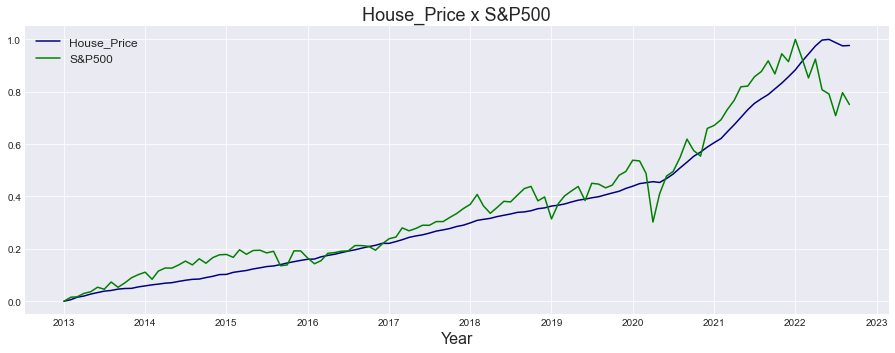

In [19]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['SP500'], color='green', label='S&P500')
ax.set_title('House_Price x S&P500', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=12);

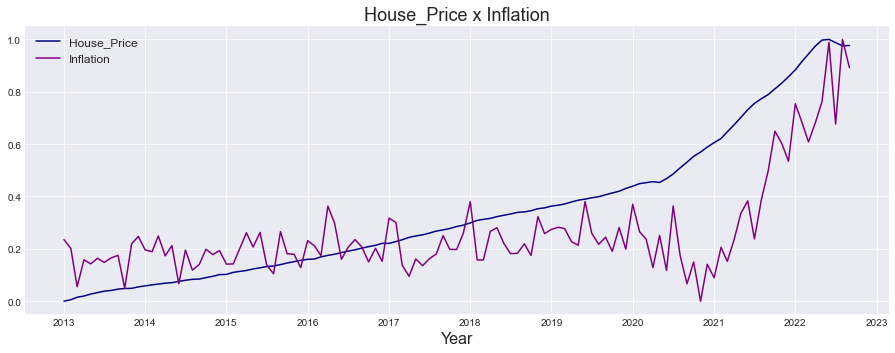

In [20]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['Inflation'], color='purple', label='Inflation')
ax.set_title('House_Price x Inflation', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=12);

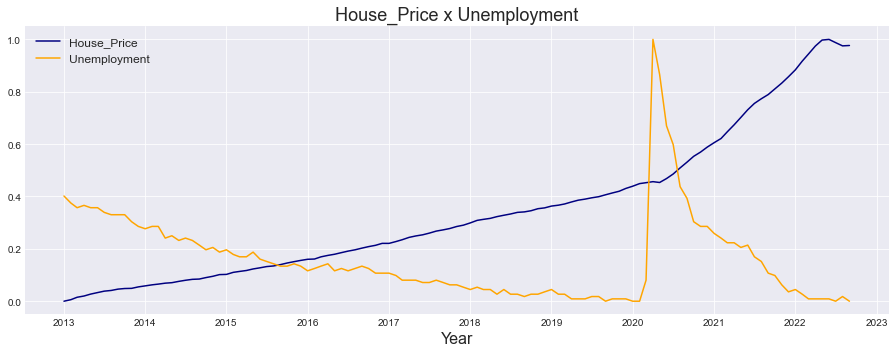

In [21]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['Unemployment'], color='orange', label='Unemployment')
ax.set_title('House_Price x Unemployment', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=12);

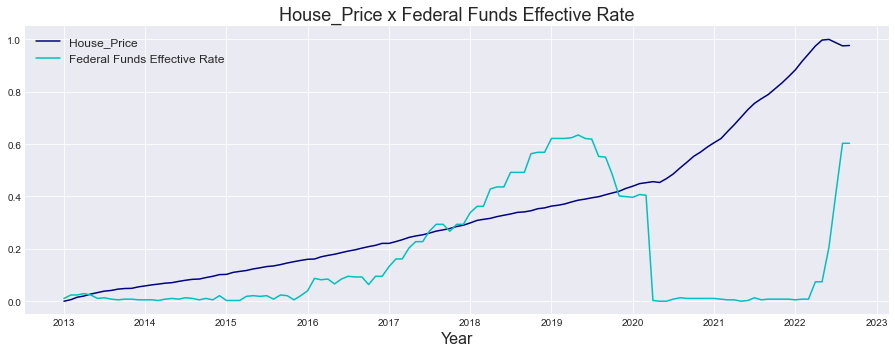

In [22]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(df_index_norm.set_index('Date')['House_Price'], color='navy', label='House_Price')
ax.plot(df_index_norm.set_index('Date')['FF_Rate'], color='c', label='Federal Funds Effective Rate')
ax.set_title('House_Price x Federal Funds Effective Rate', fontsize=18)
ax.set_xlabel("Year", fontsize=16)
sns.color_palette()
ax.legend(fontsize=12);

## Exporting Data

In [23]:
sql_password = os.getenv('sql_password')
user = "lenagrumbach"
password = sql_password
url_banco = "localhost"
nome_db = "finance_api"
conn_str = f"mysql+pymysql://{user}:{password}@{url_banco}/{nome_db}"
engine = db.create_engine(conn_str)

In [24]:
df_all_index.to_sql(name='df_all_index', con=engine,if_exists='replace', index=False)

117

In [25]:
last_update.reset_index().to_excel('last_update.xlsx', index=False)

## Sending emails

In [26]:
# importing e-mail list to send

stakeholder_list =  pd.read_excel('stakeholder_list.xlsx')
active_emails = stakeholder_list.loc[stakeholder_list['Active']=='ok']

In [27]:
table_email = build_table(last_update.reset_index(), color='blue_light', font_size='12px')

In [28]:
logging.basicConfig(level = logging.INFO, filename= 'email_report.log', encoding='utf-8')

In [29]:
def send_email(send_to, send_from='lena.dataanalyst@gmail.com', subject='Daily update'):
    dotenv.load_dotenv('senhas.env')
    gmail_password = os.getenv('gmail_password')

    body_email = f"""
    <p>Hello,

    <p> Please see below for updated information.

    {table_email}



    <p>Kind regards,
    <p>Lena Grumbach
    </p>
    """
    msg= MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = send_from
    msg['To'] = send_to
    msg.attach(MIMEText(body_email, 'html'))
    
    file_path = "C:/Users/lenag/OneDrive/Desktop/IRONHACK/Projetos/api_fred_house_price_analysis/last_update.xlsx"
    attachment = open(file_path, 'rb')
    att = MIMEBase('application','octet-stream')
    att.set_payload(attachment.read())
    encoders.encode_base64(att)
    att.add_header('Content-Disposition', f"attachment; filename=last_update.xlsx")
    attachment.close()
    msg.attach(att)

    host = 'smtp.gmail.com'
    port = '587'
    login = send_from
    password = gmail_password
    server = smtplib.SMTP(host,port)
    server.ehlo()
    server.starttls()
    server.login(login,password)
    server.sendmail(msg['From'], msg['To'], msg.as_string().encode('utf-8'))
    server.quit()

In [30]:
# Send with log file

send_list = list(active_emails['Contact']) 
confirm_list = []
for i in send_list:
    send_email(i)
    confirm_list.append(f"Sent to {i} at {datetime.today()}")
logging.info(confirm_list)
print('done')

done
